## Bank Customer Churn Prediction 

## Data


### Demographic information about customers

<b>customer_id</b> - Customer id

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>age</b> - Age of customer

<b>gender</b> - Gender of customer

<b>dependents</b> - Number of dependents

<b>occupation</b> - Occupation of the customer 

<b>city</b> - City of customer (anonymised)


### Customer Bank Relationship


<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year


### Transactional Information

<b>current_balance</b> - Balance as of today

<b>previous_month_end_balance</b> - End of Month Balance of previous month


<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>current_month_credit</b> - Total Credit Amount current month

<b>previous_month_credit</b> - Total Credit Amount previous month

<b>current_month_debit</b> - Total Debit Amount current month

<b>previous_month_debit</b> - Total Debit Amount previous month

<b>current_month_balance</b> - Average Balance of current month

<b>previous_month_balance</b> - Average Balance of previous month

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)

### Loading Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Loading Data

In [3]:
df = pd.read_csv('C:/Users/MrunmayiSA/Downloads/Customer_Churn/Customer_Churn/churn_prediction.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values  is a necessary step before we fit a logistic regression model on the dataset.

In [4]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

#### Gender

In [5]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

Since there is a good mix of males and females, missing values cannot be filled with any one of them. So I created a seperate category by assigning the value -1 for all missing values in this column.

In [6]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#### Dependents, occupation and city with mode

Imputed with mode

In [7]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [8]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [9]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

Similarly City can also be imputed with most common category 1020

In [10]:
df['city'] = df['city'].fillna(1020)

#### Days since Last Transaction
Since this is number of days since last transaction in 1 year, substituting missing values with a value greater than 1 year (999)

In [11]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

### Preprocessing

Before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric. 


### Dummies with Multiple Categories

In [12]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

### Scaling Numerical Features for Logistic Regression

There are a lot of outliers in the dataset. Also, the distributions are skewed. This is handled by:
* Log Transformation
* Standard Scaler

In [13]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [14]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [15]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

## Model Building and Evaluation Metrics
Since this is a binary classification problem, we use the following 2 metrics for model evaluation:

1. Recall
2. Area under the Receiver operating characteristic curve

### Baseline Columns

In [18]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [19]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [20]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [21]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

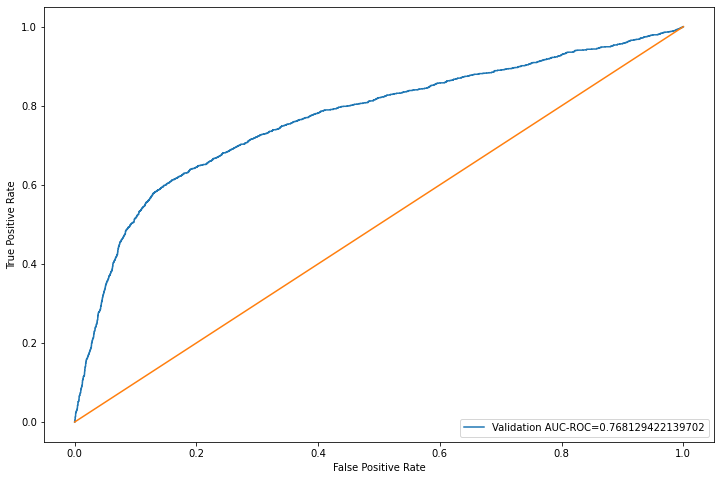

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [23]:
# Confusion Matrix
pred_val = model.predict(xtest)

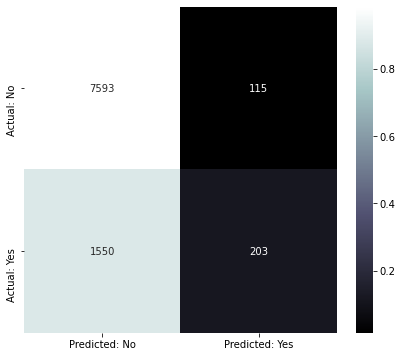

In [24]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [25]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

### Cross validation


We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

Since it builds several models on different subsets of the dataset, we can be more sure of our model performance if we use CV for testing our models.

In [26]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [27]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.7778162573219608, Recall Score: 0.0779, Precision Score: 0.6508 

3 of kfold 5
ROC AUC Score: 0.7550795074795742, Recall Score: 0.1350, Precision Score: 0.6425 

4 of kfold 5
ROC AUC Score: 0.7582107980186036, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7619218048995487, Recall Score: 0.1122, Precision Score: 0.5784 


Now let us try using all columns available to check if we get significant improvement.

In [28]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7335579077176035, Recall Score: 0.1131, Precision Score: 0.5174 

2 of kfold 5
ROC AUC Score: 0.7681325660261021, Recall Score: 0.1977, Precision Score: 0.6820 

3 of kfold 5
ROC AUC Score: 0.7392213875037825, Recall Score: 0.1673, Precision Score: 0.5714 

4 of kfold 5
ROC AUC Score: 0.7459730271553936, Recall Score: 0.1388, Precision Score: 0.6822 

5 of kfold 5
ROC AUC Score: 0.7588565033483758, Recall Score: 0.1730, Precision Score: 0.5987 


### Reverse Feature Elimination

In [29]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [30]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [31]:
ranked = ranking_df.sort_values(by=['Rank'])

In [32]:
ranked

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
7,occupation_company,3
15,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
10,occupation_self_employed,8
9,occupation_salaried,9
11,occupation_student,10


Selecting the top 10 features from this table and check score.

In [33]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.2281, Precision Score: 0.7362 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.2234, Precision Score: 0.7556 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.2205, Precision Score: 0.7250 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.2120, Precision Score: 0.7360 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.1911, Precision Score: 0.6745 


The top 10 features gave a much better score. 

Playing around with the threshold to get a better recall score.

In [34]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.8308, Precision Score: 0.2836 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.8375, Precision Score: 0.2902 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.8279, Precision Score: 0.2897 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.8213, Precision Score: 0.2840 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.8108, Precision Score: 0.2927 


[0.7986881101633954,
 0.8050442914397288,
 0.7985130070256687,
 0.7935095616193245,
 0.7942222838028076]

## Comparison of Different models

* Baseline Model
* Model based on all features
* Model based on top 10 features obtained from RFE

In [35]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot:>

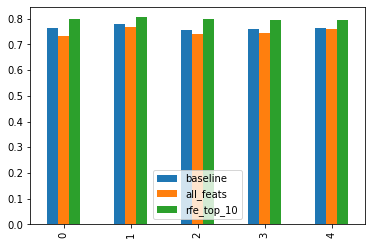

In [36]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

The model based on RFE gave the best result.